In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa, librosa.display

In [2]:
df_train_raw = pd.read_pickle('../features/train_clean.pkl')
df_test_raw = pd.read_pickle('../features/test_clean.pkl')
TARGET = "open_channels"
df_test_raw[TARGET] = 0

print(df_train_raw.shape, df_test_raw.shape)
df_train_raw.head()

(4500000, 6) (2000000, 7)


,time,signal,open_channels,local_time,batch,mini_batch
0,0.0001,-2.7600,0,0.0001,1.0,1.0
1,0.0002,-2.8557,0,0.0002,1.0,1.0
2,0.0003,-2.4074,0,0.0003,1.0,1.0
3,0.0004,-3.1404,0,0.0004,1.0,1.0
4,0.0005,-3.1525,0,0.0005,1.0,1.0


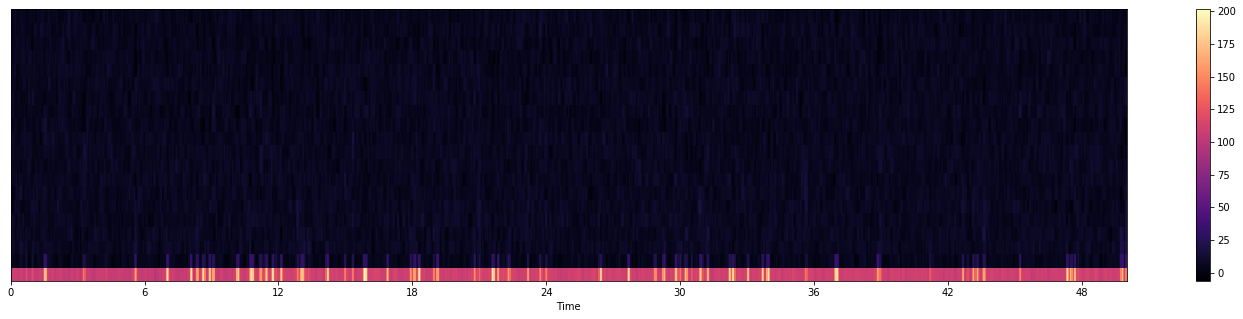

In [3]:
fs = 10000
mfcc = librosa.feature.mfcc(df_train_raw[:500000]['signal'].values.astype('float32'),  sr=fs)
plt.figure(figsize=(25, 5))
librosa.display.specshow(mfcc, sr=fs,x_axis='time')
plt.colorbar()

In [4]:
mfcc_ttf_map = {}

mfcc_mean = mfcc.mean(axis=1)

for i, each_mfcc_mean in enumerate(mfcc_mean):
    key = 'mfcc_{}'.format(i)
    if key not in mfcc_ttf_map:
        mfcc_ttf_map[key] = []
    mfcc_ttf_map[key].append(each_mfcc_mean)
    
    key = 'signal'
    if key not in mfcc_ttf_map:
        mfcc_ttf_map[key] = []
    mfcc_ttf_map[key].append(df_train_raw.iloc[-1][key])

In [5]:
# print('counting total...')
# total = 4500000
# print('total: {}'.format(total))

In [6]:
# print('generating train data...')
fragment_size = 2500
skip = 1
from tqdm import tqdm_notebook as tqdm
# you can reduce train data to process for some quick experiments
# skip = 10
batch_idx = 4
bias = 500000 * (batch_idx - 1)
mfcc_ttf_map = {}
for i in range(200):
    df = df_train_raw[i* fragment_size+bias: (i+1)*fragment_size+bias]
    mfcc = librosa.feature.mfcc(df['signal'].values.astype('float32'),  sr=fs)
    mfcc_mean = mfcc.mean(axis=1)
    for i, each_mfcc_mean in enumerate(mfcc_mean):
        key = 'mfcc_{}'.format(i)
        if key not in mfcc_ttf_map:
            mfcc_ttf_map[key] = []
        mfcc_ttf_map[key].append(each_mfcc_mean)
    key = 'signal'
    if key not in mfcc_ttf_map:
        mfcc_ttf_map[key] = []
    mfcc_ttf_map[key].append(df.iloc[-1][key])

mfcc_ttf_df = pd.DataFrame(mfcc_ttf_map)
# fname = 'mfcc_train.csv'
# mfcc_ttf_df.to_csv(fname, index=False)
# print('saved {}.'.format(fname))
        

In [7]:
print(mfcc_ttf_df.shape)
mfcc_ttf_df.head()

(200, 21)


,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,signal
0,213.321777,39.165081,11.773718,12.280483,9.173468,8.235359,6.397208,4.775072,3.952183,1.173167,...,4.673058,3.451816,1.452877,2.579231,2.801467,2.845714,-1.196862,0.479050,-0.663204,-1.4145
1,237.698517,37.419060,3.313270,9.007401,8.661616,4.793352,5.321361,6.710748,8.265577,3.536796,...,-1.115468,1.481361,5.395585,2.311445,0.510825,0.692340,2.840390,0.647276,-2.616387,1.1046
2,231.348801,40.886383,7.905387,11.244570,6.772151,7.580066,3.648921,3.759132,6.258384,5.647695,...,-1.106243,1.724887,1.247101,3.190430,6.398462,3.877682,0.800805,2.582102,1.028454,-2.9713
3,226.358612,40.371662,7.989912,10.389709,9.478437,8.688234,5.692770,5.617621,5.094223,2.651777,...,2.506910,1.959377,4.806595,4.642887,3.768365,3.084701,2.126485,1.689255,0.552529,0.6509
4,234.121307,40.840176,7.285559,11.828872,8.492124,7.381234,8.879599,3.339597,6.231389,2.836662,...,2.132216,3.585445,5.652618,2.607797,-0.135288,1.486323,1.428716,-0.268292,2.055325,-0.1855


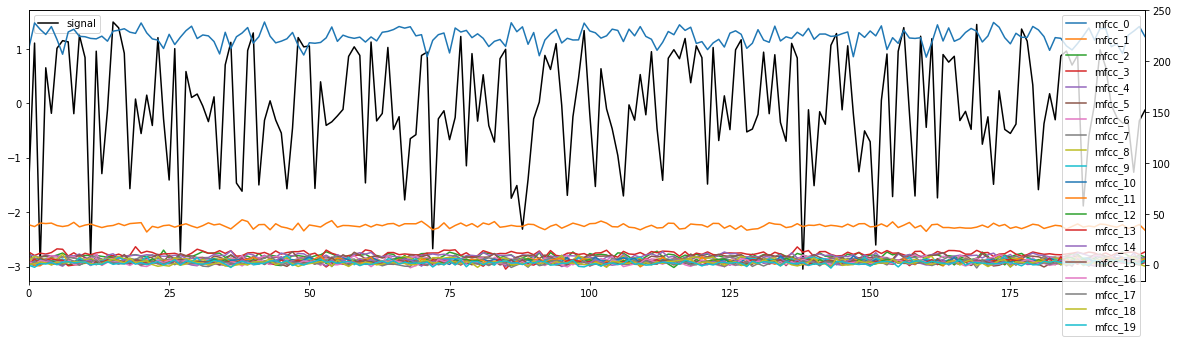

In [8]:
fig = plt.figure(figsize=[20,5])
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

mfcc_ttf_df['signal'].plot(ax=ax1, y='time_to_failure', legend=True, color='black')
ax1.legend(loc='upper left')
mfcc_ttf_df.drop(['signal'], axis=1).plot(ax=ax2, legend=True)

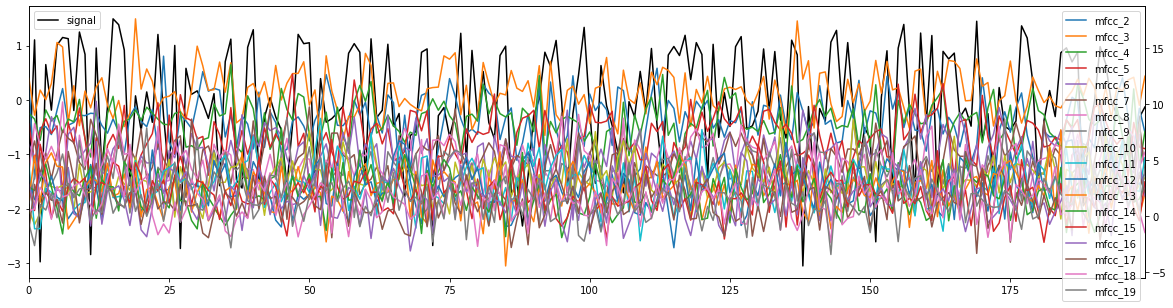

In [9]:
use_cols = [
    col for col in mfcc_ttf_df.columns
    if col not in ["mfcc_0", "mfcc_1", "signal"]
]

fig = plt.figure(figsize=[20, 5])
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

mfcc_ttf_df['signal'].plot(ax=ax1,
                           y='time_to_failure',
                           legend=True,
                           color='black')
ax1.legend(loc='upper left')

mfcc_ttf_df.drop(['signal'], axis=1)[use_cols].plot(ax=ax2, legend=True)

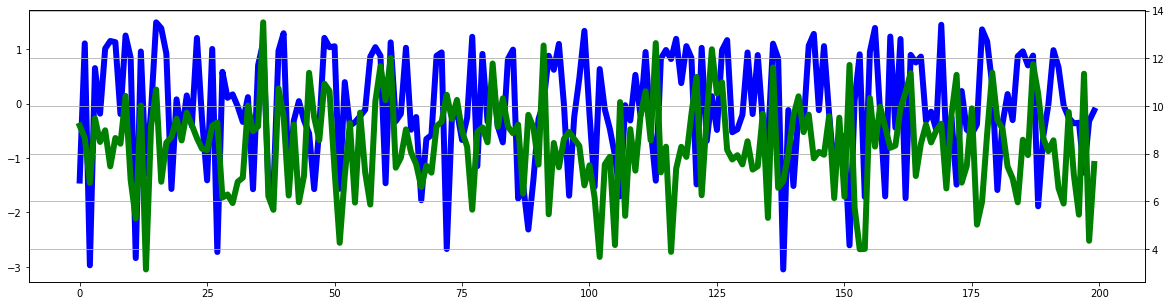

In [10]:
fig = plt.figure(figsize=[20, 5])
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ax1.plot(mfcc_ttf_df["signal"], c="b", lw=6)
ax2.plot(mfcc_ttf_df["mfcc_4"], c="g", lw=6)
plt.grid()

In [11]:
from scipy.stats import pearsonr
for col in mfcc_ttf_df.columns:
    corr, p = pearsonr(mfcc_ttf_df["signal"], mfcc_ttf_df[col])
    print(col," -- ", corr.round(3)," -- ", p.round(3))

mfcc_0  --  -0.045  --  0.525
mfcc_1  --  -0.085  --  0.234
mfcc_2  --  0.025  --  0.725
mfcc_3  --  -0.039  --  0.584
mfcc_4  --  0.056  --  0.429
mfcc_5  --  0.093  --  0.192
mfcc_6  --  0.022  --  0.754
mfcc_7  --  0.086  --  0.225
mfcc_8  --  0.021  --  0.765
mfcc_9  --  -0.098  --  0.169
mfcc_10  --  -0.074  --  0.298
mfcc_11  --  -0.009  --  0.899
mfcc_12  --  -0.056  --  0.428
mfcc_13  --  0.018  --  0.805
mfcc_14  --  -0.048  --  0.496
mfcc_15  --  0.022  --  0.756
mfcc_16  --  0.123  --  0.081
mfcc_17  --  -0.055  --  0.437
mfcc_18  --  -0.004  --  0.954
mfcc_19  --  0.005  --  0.949
signal  --  1.0  --  0.0
